<a href="https://colab.research.google.com/github/hajarelkhazri/deep_learning/blob/main/PyTorch_Lab2_newton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 PyTorch Lab 2: Newton Method for logistic regression


You already know **gradient descent**: update the parameters in the opposite direction of the gradient, with a fixed or adaptive step size.

**Newton’s method** goes a step further. Instead of using only the first derivative (the gradient), it also uses the **second derivative information** (the Hessian matrix). Around the current point, we approximate the loss by a quadratic function, then jump directly to its minimum.  

The update rule is:

$$
w_{k+1} = w_k - H^{-1}(w_k)\,\nabla f(w_k)
$$

where:  
- $ \nabla f(w_k)$ is the gradient at the current point,  
- $H(w_k)$ is the Hessian (matrix of second derivatives).  


We'll train on a small **real dataset** (Breast Cancer Wisconsin from scikit-learn). If scikit-learn isn't available, we fall back to a tiny embedded Iris-binary subset.

## 1) Setup


In [ ]:
import torch
torch.set_default_dtype(torch.float64)
print('PyTorch version:', torch.__version__)
torch.manual_seed(0)

import numpy as np
import matplotlib.pyplot as plt

# For data
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler


PyTorch version: 2.8.0+cu126


## 2) Load & prepare the data (Iris)


In [ ]:
# Load iris dataset
data = load_iris()
X = data['data']          # shape (150, 4)
y = data['target']        # classes: 0=setosa, 1=versicolor, 2=virginica

# Convert to binary classification: setosa (0) vs not-setosa (1)
y = (y != 0).astype(float)

# Standardize features
X = StandardScaler().fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.get_default_dtype())
y = torch.tensor(y, dtype=torch.get_default_dtype())

n, d = X.shape

# Add bias column (intercept)
X = torch.cat([torch.ones(n, 1, dtype=X.dtype), X], dim=1)
d = d + 1
print(f"Tensors: X={tuple(X.shape)}, y={tuple(y.shape)}, d={d}")


Tensors: X=(150, 5), y=(150,), d=5


## 3) Define the logistic loss

For a weight vector \(w \in \mathbb{R}^{d}\) and data \(X \in \mathbb{R}^{n\times d}\), labels \(y \in \{0,1\}^n\):

$$
\ell(w) = -\frac{1}{n}\sum_{i=1}^n \Big( y_i\log(\sigma(x_i^\top w)) + (1-y_i)\log(1-\sigma(x_i^\top w)) \Big),
$$

where $\sigma(t) = 1/(1+e^{-t})$ is the sigmoid.


In [ ]:
def logistic_loss(w, X, y):
    z = X @ w
    p = torch.sigmoid(z)
    eps = 1e-12
    nll = - (y * torch.log(p + eps) + (1 - y) * torch.log(1 - p + eps)).mean()
    return nll

# Initialize parameters
w = torch.nn.Parameter(torch.rand(X.shape[1], dtype=torch.get_default_dtype()), requires_grad=True)

# Quick sanity check
loss = logistic_loss(w, X, y)
print("Initial loss:", loss.item())


Initial loss: 0.23878280685050943


## 4) **Exercise:** Gradient & Hessian with `torch.autograd.functional`

**Tasks**
1. Compute the gradient of `logistic_loss` at `w`.
2. Compute the Hessian at `w`.
   
hint : torch.autograd.functional


In [4]:
# === Your work ===
# TODO: compute grad and H using the functional API
# Hint: wrap logistic_loss in a lambda that only takes w as input.

grad = torch.autograd.functional.jacobian(lambda w: logistic_loss(w,X,y),w)  # TODO
H = torch.autograd.functional.hessian(lambda w: logistic_loss(w,X,y),w)     # TODO

print("||grad||:", float(torch.norm(grad)))
print("H shape:", tuple(H.shape))

||grad||: 0.27459912425425054
H shape: (5, 5)


## 5) Gradient Descent (GD)

We implement a basic GD loop:
$$
w \leftarrow w - \alpha \nabla \ell(w).
$$

**Exercise**
- Complete the TODOs to record the loss at each epoch and update $w$.
- Use a stopping criterion based on $$ \|\nabla \ell(w)\| < \varepsilon $$


In [6]:
n_epoch = 100
alpha = 1.0          # try 0.1, 0.5, 1.0, etc.
eps = 1e-2
loss_grad = []

# Re-init w
w = torch.nn.Parameter(torch.rand(X.shape[1], dtype=torch.get_default_dtype()), requires_grad=True)

for epoch in range(n_epoch):
    # TODO: compute loss and append to loss_grad
    # TODO: compute gradient (functional jacobian)
    # TODO: update w with a GD step

    # --- your code ---
    loss = logistic_loss(w, X, y)
    loss_grad.append(float(loss))
    grad = torch.autograd.functional.jacobian(lambda w: logistic_loss(w, X, y), w)
    w = torch.nn.Parameter( w - alpha * grad, requires_grad=True)
    # --- end your code ---

    # stopping
    if torch.norm(grad) < eps :  # TODO: replace with torch.norm(grad) < eps
        print(f"GD early stop at epoch {epoch}")
        break

GD early stop at epoch 94


## 6) Newton's Method

Newton update:
$$
w \leftarrow w - H(w)^{-1} \nabla \ell(w).
$$

In practice, **solve** the linear system `H s = grad` and set `w ← w − s` to avoid explicit inversion.


In [7]:
n_epoch = 100
eps = 1e-2
loss_newton = []

# Re-init w
w = torch.nn.Parameter(torch.rand(X.shape[1], dtype=torch.get_default_dtype()), requires_grad=True)

for epoch in range(n_epoch):
    # TODO: compute loss and append to loss_newton
    # TODO: compute grad and Hessian
    # TODO: Newton step using torch.linalg.solve

    # --- your code ---
    loss = logistic_loss(w , X, y)
    loss_newton.append(float(loss))
    grad = torch.autograd.functional.jacobian(lambda w: logistic_loss(w, X, y), w)
    H = torch.autograd.functional.hessian(lambda w: logistic_loss(w,X,y),w)
    step = torch.linalg.solve(H, grad)
    w = w - step
    # --- end your code ---

    if torch.norm(grad) < eps:  # TODO: replace with torch.norm(grad) < eps
        print(f"Newton early stop at epoch {epoch}")
        break

Newton early stop at epoch 4


## 7) Compare convergence

Plot the loss trajectories of GD vs Newton.  


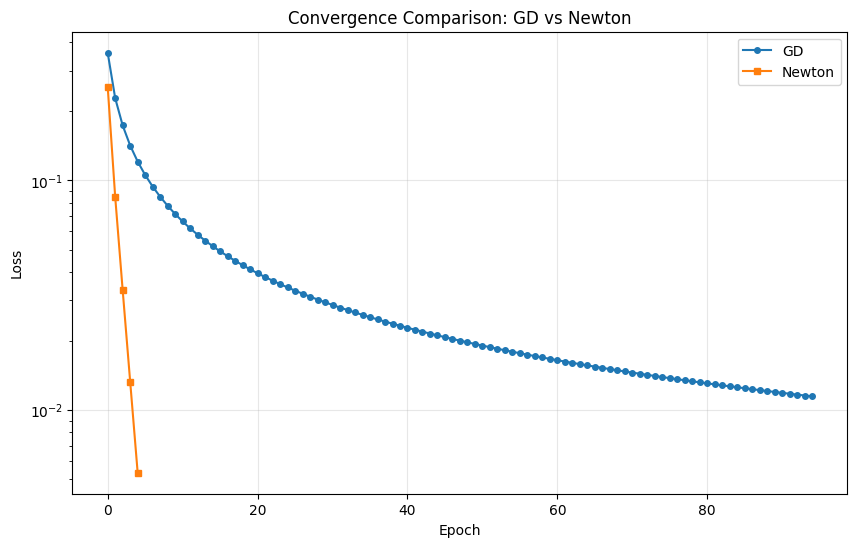

In [9]:
# Plot loss trajectories
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_grad, label='GD', marker='o', markersize=4)
plt.plot(loss_newton, label='Newton', marker='s', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convergence Comparison: GD vs Newton')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Optional: use log scale to see convergence better
plt.show()